# Tijdsverschillen tussen detectoren
Detector timing offsets

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Events

In [253]:
FILENAME = 'events.h5'
station = 501

In [2]:
from datetime import datetime
start = datetime(2015, 5, 1)
end = datetime(2015, 5, 2)

In [255]:
import tables
data = tables.open_file(FILENAME, 'a')

In [256]:
from sapphire import download_data
if '/events' not in data:
    print 'downloading events'
    download_data(data, '/', station, start, end)
else:
    print 'events already downloaded.'

events already downloaded.


In [257]:
events = data.root.events
events

/events (Table(57828,)) ''
  description := {
  "event_id": UInt32Col(shape=(), dflt=0, pos=0),
  "timestamp": Time32Col(shape=(), dflt=0, pos=1),
  "nanoseconds": UInt32Col(shape=(), dflt=0, pos=2),
  "ext_timestamp": UInt64Col(shape=(), dflt=0, pos=3),
  "pulseheights": Int16Col(shape=(4,), dflt=0, pos=4),
  "integrals": Int32Col(shape=(4,), dflt=0, pos=5),
  "n1": Float32Col(shape=(), dflt=0.0, pos=6),
  "n2": Float32Col(shape=(), dflt=0.0, pos=7),
  "n3": Float32Col(shape=(), dflt=0.0, pos=8),
  "n4": Float32Col(shape=(), dflt=0.0, pos=9),
  "t1": Float32Col(shape=(), dflt=0.0, pos=10),
  "t2": Float32Col(shape=(), dflt=0.0, pos=11),
  "t3": Float32Col(shape=(), dflt=0.0, pos=12),
  "t4": Float32Col(shape=(), dflt=0.0, pos=13),
  "t_trigger": Float32Col(shape=(), dflt=0.0, pos=14)}
  byteorder := 'little'
  chunkshape := (819,)

## Bepalen van tijdsverschil

Blabla t1 en t3 want grote offset. (Wellicht een station kiezen met een grote offset tussen t1 en t2)

In [258]:
t1 = events.col('t1')
t3 = events.col('t3')

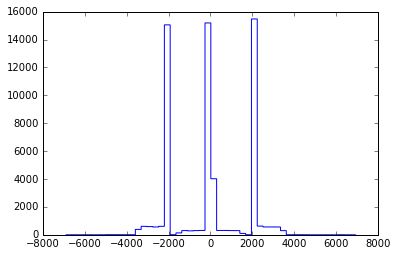

In [259]:
dt = t3 - t1
_ = plt.hist(dt, bins = 50, histtype='step')

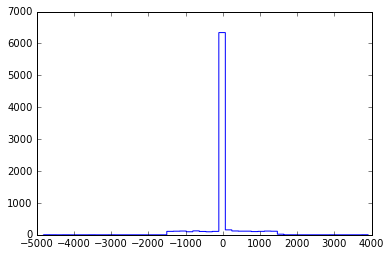

In [260]:
ph = events.col('pulseheights')
ph1 = ph[:, 0]
ph3 = ph[:, 2]
dt_1_3 = dt.compress((t1 > 0.) & (t3 > 0.) & (ph1 > 200.) & (ph3 > 200.))
_ = plt.hist(dt_1_3, bins=50, histtype='step')

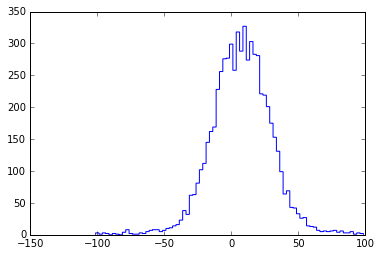

In [261]:
bins=np.arange(-101.25, 101.25, 2.5)
n, _, _ = plt.hist(dt_1_3, bins=bins, histtype='step')

## Detectoroffset bepalen uit het histogram

In [262]:
np.mean(dt_1_3)

5.9358568

In [263]:
def gauss(x, N, mu, sigma):
    """Gaussian distribution"""
    return N * np.exp(-0.5 * ((x - mu) / sigma) ** 2 )

In [264]:
from scipy.optimize import curve_fit
x = (bins[:-1] + bins[1:]) / 2
popt, pcov = curve_fit(gauss, x, n)
N, mu, sigma = popt
mu, sigma

(7.6771134598536186, 20.139014319345481)

(-60, 70)

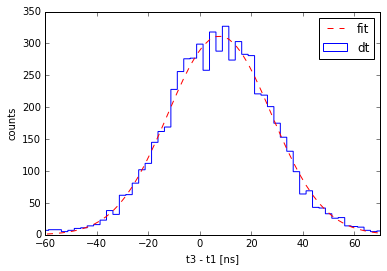

In [265]:
plt.hist(dt_1_3, bins=bins, histtype='step')
plt.plot(bins, gauss(bins, N, mu, sigma), 'r--')
plt.legend(['fit','dt'])
plt.xlabel('t3 - t1 [ns]')
plt.ylabel('counts')
plt.xlim((-60, 70))

In [266]:
from sapphire import Station
s501 = Station(501)

## Detector offsets ophalen mbv de API

In [267]:
from sapphire.transformations.clock import datetime_to_gps
ts = datetime_to_gps(datetime(2016,5,1))
ts

1462060800

In [268]:
s501.detector_timing_offset(ts)

[-1.25, 0.0, 5.25, 4.5]

In [269]:
o1, o2, o3, o4 = s501.detector_timing_offset(ts)
o3 - o1

6.5

In [270]:
data.close()